In [1]:
import pandas as pd
from utils import *
from models import *
import shap
import xgboost as xgb
import warnings

# Modelo

A continuación presento los modelos construidos para la detección de fraude. El código de como se construye todo los modelos se encuentra en el script `models.py`, pero básicamente es una clase que alista los datos, y entrena. En este caso usare un modelo de gradient boosting debido a sus buenas capacidades de clasifiación (`Xgboost`) y un perceptron de red neuronal (`pytorch`). En el caso del gradient boosting puede usar un optimizador de hyperparametros (`optuna`) que busca evitar el overfitting. 

In [2]:
# Declaración de la clase construida
df = pd.read_csv("ds_challenge_2021.csv")
rappi = Rappi_fraude(df)

## Alistamiento de datos

Debido a que los datos estan muy desbalanceados es necesario hacer un balanceo. El problema es que esto genera que nos quedemos con muy pocos datos, haciendo que el modelo no tenga las suficientes muestras para aprender. Las variables categoricas son decodificadas en one-hot debido a que no se tiene una jerarquía clara entre las variables para pasarlo a valores numéricos. Todo esto lo hace el método `.parsing()`

In [5]:
# Balanceo y alistamiento de los datos.
columns = ["genero","hora","monto","establecimiento","ciudad","tipo_tc","linea_tc","interes_tc","status_txn",'is_prime', 'dcto', 'cashback','dispositivo']
rappi.parsing(label = "fraude",balance=True,columns=columns, dummy_na=True)

## Train



### Xgboost

El método `.train_xgb()` permite entrenar un modelo de Xgboost para la tarea indicada y nos retorna los valores de reales y de predicción para poder hacer los testeo. Adicionalmente el modelo se encuentra en `._xgb_model`. Primero muestro un modelo de xgboost con optuna y después sin optuna.

In [6]:
y_pred_test, y_test, y_pred_train, y_train = rappi.train_xgb(tune="prueba1",n_trials=10)

[I 2021-08-19 15:17:17,040] Using an existing study with name 'rappi_prueba1' instead of creating a new one.


Tuning regressor!.....
prueba1 0
[15:17:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [7]:
to_max_1 = f1_score(y_pred_test, y_test)
to_max_2 = f1_score(y_pred_train, y_train)
print("Confussion matrix train")
print(confusion_matrix(y_train,y_pred_train))
print("Confusion matrix test")
print(confusion_matrix(y_test,y_pred_test))
print("F1 score test:",to_max_1)
print("F1 socre train:",to_max_2)

Confussion matrix train
[[  0 550]
 [  0 535]]
Confusion matrix test
[[  0 260]
 [  0 275]]
F1 score test: 0.6790123456790123
F1 socre train: 0.6604938271604938


In [12]:
y_pred_test, y_test, y_pred_train, y_train = rappi.train_xgb(tune=None)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [13]:
to_max_1 = f1_score(y_pred_test, y_test)
to_max_2 = f1_score(y_pred_train, y_train)
print("Confussion matrix train")
print(confusion_matrix(y_train,y_pred_train))
print("Confusion matrix test")
print(confusion_matrix(y_test,y_pred_test))
print("F1 score test:",to_max_1)
print("F1 socre train:",to_max_2)

Confussion matrix train
[[578   0]
 [  0 556]]
Confusion matrix test
[[126 106]
 [138 116]]
F1 score test: 0.4873949579831932
F1 socre train: 1.0


#### Análisis

La métrica que utilizo para evaluar el modelo es f1 score, ya que en general es la indicada para clasificaciones binarias. En el caso del model de Xgboost se tiene una versión con hyperpárametros y otra con parámetros genéricos. Cuando se hace la optimización de hyperparámetros se busca no tener overfitting, es decir que la diferencia entre el error en test y train no sea muy grande. El problema es que los mejores parámetros apuntan a un modelo en el cual todos los asocia a una sola categoría, en este caso fraude, como lo evidencia la matrix de confusión. Esta es la mejor condición que mejora el error pero evita el overfitting. Ahora, si uitlizamos otros parámetros caemos en un modelo de overfitting. Esto se debe principalmente a que no hay una diferencia marcada entre las distribuciones de probabilidad entre transacciones fraudulentas y no fraudulentas, como se ve en análisis de datos hecho. Sin embargo, el modelo sin optimizar sigue siendo mejor ya que no cae en el problema de identificar todo como una sola categoría, así que con este haremos otros análisis.

In [14]:
explainer = shap.TreeExplainer(rappi._xgb_model)

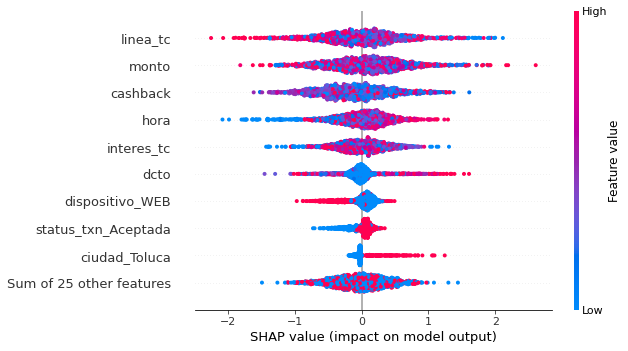

In [15]:
shap_values = explainer(rappi._Xtrain)

# visualize the first prediction's explanation
shap.plots.beeswarm(shap_values)

Los modelos de Machine Learning tienen la tradicional idea de que son "Cajas negras" y realmente entender cuales son las relaciones que aprende el modelo es imposible. Para una compañía mas allá de las predicciones también esta muy interesado en saber cuales son las relaciones que aprende un modelo, para usarlas a la hora de resolver las preguntas de negocio. Para esto se diseño la línea de investigación ML intepretable. En este presonto un gráfico de shap que permite ver las relaciones que tienen las features en las predicciones. Por ejemplo, analizando `ciudad_Toluca` podemos observar que el tener un valor alto  (1), es decir que la transacción sea en toluca favorece el valor que se obtiene en la predicción, en este caso ser fraude, por otra parte el valor bajo, no ser de toluca, desfavorece a que el modelo prediga un fraude. Esto se entiende que el modelo aprendio esta tendencia en su entrenamiento. En general si el modelo es muy bueno podriamos observar muchas relaciones muy interesantes que ayudarían a resolver preguntas de negocio en parituclar tendencias que marquen las transacciones fraudulentas 

### Perceptron (red neuronal)

También hice un modelo de red neuronal sencillo pero los resultados son muy similares a los obtenidos con xgboost

In [16]:
y_pred_list, y_test = rappi.train_nn(EPOCHS = 60,BATCH_SIZE = 64,LEARNING_RATE = 0.001)

Epoch 001: | Loss: 0.72169 | Acc: 49.588
Epoch 002: | Loss: 0.67892 | Acc: 57.235
Epoch 003: | Loss: 0.67149 | Acc: 60.235
Epoch 004: | Loss: 0.66441 | Acc: 61.588
Epoch 005: | Loss: 0.65716 | Acc: 62.765
Epoch 006: | Loss: 0.64865 | Acc: 63.118
Epoch 007: | Loss: 0.64050 | Acc: 64.882
Epoch 008: | Loss: 0.63124 | Acc: 66.059
Epoch 009: | Loss: 0.62139 | Acc: 68.647
Epoch 010: | Loss: 0.60923 | Acc: 69.706
Epoch 011: | Loss: 0.59672 | Acc: 70.588
Epoch 012: | Loss: 0.58434 | Acc: 70.059
Epoch 013: | Loss: 0.56890 | Acc: 72.941
Epoch 014: | Loss: 0.55338 | Acc: 73.235
Epoch 015: | Loss: 0.53764 | Acc: 74.294
Epoch 016: | Loss: 0.52312 | Acc: 77.118
Epoch 017: | Loss: 0.50571 | Acc: 77.353
Epoch 018: | Loss: 0.48709 | Acc: 77.647
Epoch 019: | Loss: 0.47277 | Acc: 79.000
Epoch 020: | Loss: 0.45441 | Acc: 80.824
Epoch 021: | Loss: 0.43684 | Acc: 81.941
Epoch 022: | Loss: 0.41693 | Acc: 82.000
Epoch 023: | Loss: 0.39759 | Acc: 84.588
Epoch 024: | Loss: 0.37990 | Acc: 86.059
Epoch 025: | Los

In [18]:
confusion_matrix(y_test, y_pred_list)

array([[141, 119],
       [151, 124]])

In [19]:
f1_score(y_test, y_pred_list)

0.47876447876447875

In [20]:
rappi._nn_model

Perceptron(
  (layer_1): Linear(in_features=34, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

## Prediciones 

In [21]:
predicciones = rappi.predict_xgb(pd.get_dummies(df[columns], dummy_na=True).iloc[0:10])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [22]:
print(predicciones)

[1, 1, 1, 0, 0, 0, 0, 0, 0, 0]


## Guardar y Cargar

Finalmente el modelo que entrenamos puede ser guardado y cargado rapidamente para usarlo

In [23]:
# Save
rappi.save_xgb(path="models/final.model")

In [24]:
# load
rappi.load_xgb("models/final.model")

In [25]:
predicciones = rappi.predict_xgb(pd.get_dummies(df[columns], dummy_na=True).iloc[0:10])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [26]:
predicciones

[1, 1, 1, 0, 0, 0, 0, 0, 0, 0]

## Conclusiones

Aunque el modelo no es de muy buena calidad debido a la falta de estructura en la data y que no expresan las relaciones necesarias para poder entrenarlo adecuadamente, la metodología propeusta sería muy provechosa. Primero, la implementación y uso es muy rápida y con una buena data permitiría obtener muy buenos resultados. Segundo, el uso de herramientas como shap sería de mucha utilidad para entender aquellas relaciones complejas que asistirían en la toma de decisiones en una compañía. Las expresibidad de las relaciones complejas de este modelo sería un factor diferencial. Finalmente podemos decir que no hay features más importantes para la predición debido a la estructura de los datos, aunque si tuvieramos features más relevantes para el modelo, la metodología lo detectaría.